A barebone implementation of inverse binomial sampling (IBS)

In [1]:
import numpy as np
import numpy.random as npr

In [2]:
def ibs_basic(fun, theta, R, S=None):
    """Returns an unbiased estimate L of the log-likelihood for the
    simulated model and data, calculated using inverse binomial sampling.

    Input:
    fun: function
        A function handle to a function that simulates the model's responses. Takes as input
        a vector of parameters 'theta' and a row of 'S', and generates one row of the
        response matrix.
    theta: np.array
        used as input to fun to generate the response
    R: np.array
        response matrix, each row corrisponds to one observation and
        each column to a response feature
    S: np.array, optional
        stimulus matrix, each row corrisponds to one observation

    Returns:
    L : float
        The log-likelihood.
    """
    N = len(R)
    L = np.zeros(N)
    for i in range(N):
        K = 1
        while not (fun(theta, S[i]) == R[i]).all():
            K += 1  # Sample until the generated response is a match
        L[i] = -np.sum(1 / np.arange(1, K))  # IBS estimator for the i-th trial

    return np.sum(L)  # Return summed log-likelihood

In [3]:
def psycho_gen(theta, S):
    """
    Generate responses for psychometric function model
    (simple orientation discrimination task).

    Inputs:
    S: np.array
        stimulus orientation (in deg) for each trial
    theta: np.array with 3 elements
        model parameter vector, with THETA(0) as eta=log(sigma),
        the log of the sensory noise; THETA(1) the bias term;
        THETA(2) is the lapse rate

    Returns:
    R: np.array
        responses per trial, 1 for "rightwards" and -1 for "leftwards"
    """
    # Extract model parameters
    sigma = np.exp(theta[0])
    bias = theta[1]
    lapse = theta[2]

    # Noisy measurement
    X = S + sigma * npr.randn(np.size(S))

    # Decision rule
    R = np.zeros(np.size(S))
    R[X >= bias] = 1
    R[X < bias] = -1

    # Lapses
    lapse_idx = npr.rand(np.size(S)) < lapse
    lapse_val = npr.randint(2, size=np.sum(lapse_idx)) * 2 - 1
    R[lapse_idx] = lapse_val

    return R

In [4]:
from scipy.stats import norm


def psycho_nll(theta, S, R):
    """Negative log-likelihood for psychometric function model.

    Inputs:
    S: np.array
        stimulus orientation (in deg) for each trial
    theta: np.array with 3 elements
        model parameter vector, with THETA(1) as eta=log(sigma),
        the log of the sensory noise; THETA(2) the bias term;
        THETA(3) is the lapse rate
    R: np.array
        vector of responses, 1 for "rightwards" and -1 for "leftwards"

    Returns:
    L: float
        negative log-likelihood
    """

    # Extract model parameters
    sigma = np.exp(theta[0])
    bias = theta[1]
    lapse = theta[2]

    # Likelihood per trial (analytical solution)

    p_vec = lapse / 2 + (1 - lapse) * (
        (R == -1) * norm.cdf(-(S - bias) / sigma)
        + (R == 1) * norm.cdf((S - bias) / sigma)
    )

    # Total negative log-likelihood
    L = -np.sum(np.log(p_vec))

    return L

In [12]:
# Generate simulated dataset

Ntrials = 600
eta = np.log(1)  # Fake subject (log) sensory noise
bias = 0.2  # Fake subject response bias
lapse = 0.03  # Fake subject lapse rate
# Generating parameter vector
theta_true = np.array([eta, bias, lapse])

# Generate stimulus orientation per trial
S = 3 * npr.rand(Ntrials)

# Generate fake subject responses
R = psycho_gen(theta_true, S)


print("exact log-likelihood:", -psycho_nll(theta_true, S, R))
print("log-likelihood obtained with IBS:", ibs_basic(psycho_gen, theta_true, R, S))

exact log-likelihood: -225.93636976003535
log-likelihood obtained with IBS: -223.4090520812913


I want to check the unbiasedness of the estimator by demonstrating that the log-likelihood estimates are centred on the true value.
The bias_check function calculates 1000 log-likelihood estimates and returns an array with the difference between the estimates and the true value. A histogram of these estimates is then plotted. It can be seen that the distribution is centred around 0 and approximately Gaussian.

In [13]:
def bias_check(Ntrials, theta, nreps=1000):
    """Retrun the bias of the IBS estimator for the log-likelihood.

    Inputs:
    Ntrials: int
        number of trials for which to calculate the log-likelihood
    theta: np.array
        model parameter vector, with THETA(1) as eta=log(sigma),
        the log of the sensory noise; THETA(2) the bias term;
        THETA(3) is the lapse rate
    nreps: int, optional
        number of repetitions to calculate the bias

    Returns:
    b: np.array
        bias (estimate - true value) of the IBS estimator for the log-likelihood
        vector of length nreps
    """

    # Generate stimulus orientation per trial
    S = 3 * npr.rand(Ntrials)

    # Calculate bias = estimate - true value
    b = np.zeros(nreps)
    for i in range(nreps):
        R = psycho_gen(theta, S)
        L = psycho_nll(theta, S, R)
        b[i] = L + ibs_basic(psycho_gen, theta, R, S)
    return b

The mean of the bias is -0.28254499204167816


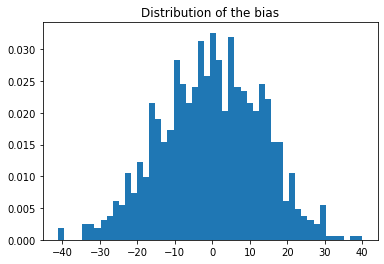

In [14]:
import matplotlib.pyplot as plt

Ntrials = 600
eta = np.log(1)
bias = 0.2
lapse = 0.03
theta_true = np.array([eta, bias, lapse])
b = bias_check(Ntrials, theta_true)
plt.hist(b, bins=50, density=True)
plt.title("Distribution of the bias")
print("The mean of the bias is", np.mean(b))